# Galaxy Selector MOC

**Compared to the "Simple Galaxy Selector, this works with Multi-Ordering-Sky-Maps**


***NOTE (this note may be wrong, just copied from old notebook)***: Before anything can happen, download the GW event localization map. Open the terminal and type:
"curl -O https://gracedb.ligo.org/api/superevents/sid/files/bayestar.fits,0"
with sid = superevent ID (could be incorporated into this notebook)

Select the galaxies to observe by WWFI in this simple manner:
- get the LIGO event data
- read the LIGO event data into the notebook, extract some information
- read the DESI database into the notebook, "clean" the data
- get the 99% credible regions for the event, add them as a column to the data
- only keep data within the 99% region
- calculate all the luminosities (& more)
- rank them by luminosity (for now just print the TARGETID), 3D/2D localization and with a luminosity-distance 2D dependant counterpart likelihood

Sources: 
- https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10
- https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html
- https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html
- https://arxiv.org/pdf/1710.05452.pdf

## Import all libraries, load GW data and DESI data and extract basic info

### imports, GW data loading

In [1]:
import numpy as np
from scipy.stats import norm
import scipy as sc

from astropy.io import fits, ascii
from astropy.table import Table, hstack
from astropy import table

#import healpy as hp
import astropy_healpix as ah

from astropy.table import QTable

import psycopg2

from scipy.stats import norm


from astropy.cosmology import Planck18, z_at_value
from astropy.coordinates import Distance, SkyCoord
from astropy import units as u

import astropy.constants as asc

import matplotlib.pyplot as plt

import requests as rq

import gasel as gs

import shutil

In [2]:
# specify the superevent name:
superevent_name = "S230606z"

In [3]:
pipeline_type = "bayestar"

path = f"/global/homes/j/jgassert/ligo-desi-gw-follow-up/Galaxy Selection/Files/{superevent_name}{pipeline_type}.multiorder.fits,1"

try:
    skymap = QTable.read(path)
    print("read skymap from local file")
    
except:
    download_url = f"https://gracedb.ligo.org/api/superevents/{superevent_name}/files/{pipeline_type}.multiorder.fits,1"
    save_path = f"Files/{superevent_name}{pipeline_type}.multiorder.fits,1"
    print("no local skymap...")
    print(f"...will download LIGO event file from superevent {superevent_name}, corresponding file URL is {download_url} and save it in .../Files/")
    
    response = rq.get(download_url, allow_redirects = True)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            #response.raw.decode_content = True
            #shutil.copyfileobj(response.raw, f)
            #print(response.content)
            f.write(response.content)
            
        skymap = QTable.read(path)

read skymap from local file


Specifiy the path where the data is located and then load the data (this loads everything, just have a look)

In [4]:
skymap[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
1029,0.019599843338698235,387.4171580454321,2035.5499043885234,3.597397977063981e-07
1040,0.0032460628931672416,893.8982011890348,1897.7038012717908,2.775336037544377e-07
1041,0.000660523727795567,inf,1.0,0.0
1042,0.009212992599255036,1056.9819640079818,1663.2308805554057,2.909496716626531e-07
1043,0.0014765584966860428,-4693.32915826326,2799.8555054310364,8.877449774149851e-06


### Get basic values from GW event

We now extract some basic information  from the healpix data:
- ipix_max: pixel with highest likelihood
- npix: total number of pixels
- ra, dec: ra and dec of the pixel with the highest likelihood

Then we open the full fits file and extract some more basic info from the header:
- dist_mean: mean distance of the GW event
- dist_std: error of the distance

In [5]:
# most probable sky location
i = np.argmax(skymap["PROBDENSITY"])
uniq = skymap[i]["UNIQ"]
print("UNIQ ID of highest prob sky localization: ", uniq)

UNIQ ID of highest prob sky localization:  703076


In [6]:
# calculate the most probable pixel, convert to RA and dec
level_max, ipix_max = ah.uniq_to_level_ipix(uniq)
nside = ah.level_to_nside(level_max)
ra, dec = ah.healpix_to_lonlat(ipix_max, nside, order = "nested")
print("Highest probability at (RA, dec): ", ra.deg, dec.deg, "with prob [1/deg^2] of: ", skymap[i]['PROBDENSITY'].to_value(u.deg**-2), "and UNIQ ID: ", skymap[i]["UNIQ"])

Highest probability at (RA, dec):  150.1171875 9.442777526802821 with prob [1/deg^2] of:  0.001325465889562678 and UNIQ ID:  703076


Now open the fits file and read basics info from the header

In [7]:
fits_gw = fits.open(path)
header = fits_gw[1].header
dist_mean = header["DISTMEAN"]
dist_std = header["DISTSTD"]
print("The dist_mean and dist_std values: ", dist_mean*u.Mpc, dist_std*u.Mpc)

The dist_mean and dist_std values:  4496.887061114983 Mpc 2023.244821059532 Mpc


In [8]:
most_likely_z = z_at_value(Planck18.luminosity_distance, dist_mean*u.Mpc, zmax = 5)
most_likely_z_std = z_at_value(Planck18.luminosity_distance, dist_std*u.Mpc, zmax = 5)

In [9]:
most_likely_z, most_likely_z_std

(<Quantity 0.71465796 redshift>, <Quantity 0.36674819 redshift>)

### Get DESI data

Load the full daily data from the file, which only includes good redshift objects

In [10]:
follow_up_others = False

In [11]:
if follow_up_others:
    center_ra = 235.9839
    center_dec = 15.2248
    radius = 1/360
    z_others = 0
    z_others_std = 0.4
    
    sigma_accuracy = 3
    
    data = gs.db_doall(center_ra, center_dec, radius)
    
    #ii = data["Z"]-sigma_accuracy*data["ZERR"]<z_others+sigma_accuracy*z_others_std
    #ii &= data["Z"]+sigma_accuracy*data["ZERR"]>z_others-sigma_accuracy*z_others_std
    
    #data = data[ii]
    
    
else:
    data = Table.read("/global/homes/j/jgassert/good_z_data_BGSBright.fits")

In [12]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
39627322533350395,11.2017136545986,-19.3753250062112,20211215,0.274138421339174,7.3501930183854e-05,0,7.64354562759399,29.5323829650879,61.7763519287109,GALAXY,131074,0.0190095156431198,6.0
39627322533353907,11.3031570730046,-19.3778160129495,20211215,0.160812674805974,3.74070815089717e-05,0,21.8182907104492,44.3453521728516,74.1602554321289,GALAXY,131074,0.0181874949485064,1.12676537036896
39627322701120343,21.7265690067643,-19.404267970287,20211022,0.0347373193412903,3.04502283257839e-06,0,30.611120223999,40.2380104064941,47.7578353881836,GALAXY,131074,0.026496633887291,0.66505241394043
39627322701120643,21.7335960725857,-19.3756051133826,20211022,0.252243092187585,4.24386834432005e-05,0,19.3021106719971,69.4891662597656,144.997436523438,GALAXY,131074,0.0254172254353762,5.25417852401733
39627322701122007,21.7682640928066,-19.3895060286576,20211022,0.272183664497557,7.48448457991176e-06,0,10.1746435165405,19.1892528533936,29.1437644958496,GALAXY,131074,0.0247003585100174,0.544734835624695


## Do all the calculations, selections,...

- turn the daily DESI data into a Table
- do some basic data selection stuff: only keep good + positive redshifts, only positive values of r-band flux and eliminate duplicates (right now simply takes the first entry)
- add the ipix (healpix) pixel value for each target
- calculate the probability for each target
- add these values to the Table ("PROB"), select only targets within the 99% credible region (i.e. with a certainty of 99% the GW event is inside this region)
- calculate the distances and its errors from the redshift, add to the data table
- calculate the 3D probability just like here: https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10 (§4) and add these values to the table
- sort the table by its 3D probability (descending)
- calculate absolute and apparent magnitude, luminosity and add to table

The final step is to include the calculation of the most likely host galaxy from https://arxiv.org/pdf/1710.05452.pdf (GW170817); these values are then also added to the table as "P_GAL"

In [13]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
39627322533350395,11.2017136545986,-19.3753250062112,20211215,0.274138421339174,7.3501930183854e-05,0,7.64354562759399,29.5323829650879,61.7763519287109,GALAXY,131074,0.0190095156431198,6.0
39627322533353907,11.3031570730046,-19.3778160129495,20211215,0.160812674805974,3.74070815089717e-05,0,21.8182907104492,44.3453521728516,74.1602554321289,GALAXY,131074,0.0181874949485064,1.12676537036896
39627322701120343,21.7265690067643,-19.404267970287,20211022,0.0347373193412903,3.04502283257839e-06,0,30.611120223999,40.2380104064941,47.7578353881836,GALAXY,131074,0.026496633887291,0.66505241394043
39627322701120643,21.7335960725857,-19.3756051133826,20211022,0.252243092187585,4.24386834432005e-05,0,19.3021106719971,69.4891662597656,144.997436523438,GALAXY,131074,0.0254172254353762,5.25417852401733
39627322701122007,21.7682640928066,-19.3895060286576,20211022,0.272183664497557,7.48448457991176e-06,0,10.1746435165405,19.1892528533936,29.1437644958496,GALAXY,131074,0.0247003585100174,0.544734835624695


### data clean up

In [14]:
#data = data[data["Z"]> 0]
#data = data[data["ZWARN"] == 0]

In [15]:
#data = data[data['FLUX_Z']>0]
data = table.unique(data, keys = "TARGETID")

In [16]:
data = data[data["TARGETID"]>0]

In [17]:
print(f"We have {len(data)} objects in the full catalog") 

We have 7184940 objects in the full catalog


### Calculate the healpix id for every object in the catalog and its probability; append this data to the Table

In [18]:
max_level = 29 # highest possible HEALPix resolution that can be represented in a 64-bit signed integer
max_nside = ah.level_to_nside(max_level)
level, ipix = ah.uniq_to_level_ipix(skymap["UNIQ"])

index = ipix*(2**(max_level-level))**2

sorter = np.argsort(index)

# this is the NESTED pixel index of the target sky location, NOT THE UNIQ ID
match_ipix = ah.lonlat_to_healpix(data["TARGET_RA"]*u.deg, data["TARGET_DEC"]*u.deg, max_nside, order='nested')

# here we get the pixel index (i.e. where the entry is in the table, also NOT THE UNIQ ID) of each target
sorter_i = sorter[np.searchsorted(index, match_ipix, side='right', sorter=sorter) - 1]
probdensity = skymap[sorter_i]['PROBDENSITY'].to_value(u.deg**-2)

# now we calculate the UNIQ ID for all our targets:

uniq = skymap["UNIQ"][sorter_i]
#to make things easier in future, I will now also append the UNIQ pixels DISTMU, DISTSIGMA and DISTNORM values. However, be careful, since these DO NOT CORRESPOND THE TARGETS IN DESI DIRECTLY!

distmu = skymap[sorter_i]["DISTMU"]
distsigma = skymap[sorter_i]["DISTSIGMA"]
distnorm = skymap[sorter_i]["DISTNORM"]


In [19]:
# len(UNIQ), len(data), len(skymap)

In [20]:
#data = data.keep_columns(["TARGETID", "TARGET_RA", "TARGET_DEC", "TILEID", "NIGHT", "Z", "ZERR", "ZWARN", "DELTACHI2", "FLUX_Z", "BGS_TARGET", "EBV", "SERSIC", "MWS_TARGET", "FILENAME"])
                          

In [21]:
data = hstack([data, Table({"UNIQ": uniq}), Table({"PROBDENSITY": probdensity}), Table({"DISTMU": distmu}), Table({"DISTSIGMA": distsigma}), Table({"DISTNORM": distnorm})])

In [22]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64
39627322533350395,11.2017136545986,-19.3753250062112,20211215,0.274138421339174,7.3501930183854e-05,0,7.64354562759399,29.5323829650879,61.7763519287109,GALAXY,131074,0.0190095156431198,6.0,2076,5.359977041958253e-08,982.9068010846312,219.3986733037057,9.859584307247734e-07
39627322533353907,11.3031570730046,-19.3778160129495,20211215,0.160812674805974,3.74070815089717e-05,0,21.8182907104492,44.3453521728516,74.1602554321289,GALAXY,131074,0.0181874949485064,1.12676537036896,2076,5.359977041958253e-08,982.9068010846312,219.3986733037057,9.859584307247734e-07
39627322701120343,21.7265690067643,-19.404267970287,20211022,0.0347373193412903,3.04502283257839e-06,0,30.611120223999,40.2380104064941,47.7578353881836,GALAXY,131074,0.026496633887291,0.66505241394043,2069,1.4027590558401122e-07,-1112.5700569988471,1181.7468153236198,8.35994089961374e-06
39627322701120643,21.7335960725857,-19.3756051133826,20211022,0.252243092187585,4.24386834432005e-05,0,19.3021106719971,69.4891662597656,144.997436523438,GALAXY,131074,0.0254172254353762,5.25417852401733,2069,1.4027590558401122e-07,-1112.5700569988471,1181.7468153236198,8.35994089961374e-06
39627322701122007,21.7682640928066,-19.3895060286576,20211022,0.272183664497557,7.48448457991176e-06,0,10.1746435165405,19.1892528533936,29.1437644958496,GALAXY,131074,0.0247003585100174,0.544734835624695,2069,1.4027590558401122e-07,-1112.5700569988471,1181.7468153236198,8.35994089961374e-06


In [23]:
print(f"The highest and lowest probability values in our catalog are: {np.min(probdensity)} and {np.max(probdensity)}")

The highest and lowest probability values in our catalog are: 5.075197621715801e-21 and 0.001325465889562678


### Sort the skymap table and get 99% credible region

In [24]:
# copy the table
skymap_sort = Table(skymap, copy = True)

In [25]:
# check whether copy worked:
# skymap_sort, skymap
# np.max(skymap["UNIQ"])

In [26]:
# now sort the skymap by its probability (descending)
skymap_sort.sort('PROBDENSITY', reverse=True)

In [27]:
# this shows the first entries sorted be their probability
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
703076,4.351247838980323,1413.6713646724643,391.4435717005969,4.6475050409402765e-07
703078,4.3491122393907995,1409.1734690191358,393.5062904965263,4.6715568676211496e-07
703073,4.328129085626749,1423.9564068240359,396.27674472776425,4.5773207103118723e-07
703079,4.3151589045688485,1398.6305326046115,389.0377955473389,4.7449248372055416e-07
703075,4.303124577151972,1419.5273746100486,398.5117921645866,4.60009912562234e-07


In [28]:
# now get 99% credible region area

level, ipix = ah.uniq_to_level_ipix(skymap_sort['UNIQ'])
pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # this is the area each pixel contains

# calculate the probability per pixel (careful: since the pixels differ in size, this is not neceseraliy a useful quantity
prob = pixel_area * skymap_sort['PROBDENSITY']

# calc cumsum of probabilities and get index of pixel that sums up to 0.99
cumprob = np.cumsum(prob)
i = cumprob.searchsorted(0.99)

# print area
area_99 = pixel_area[:i].sum()
area_99.to_value(u.deg**2)

13576.414004935838

### can be deleted, just tried things out

In [29]:
skymap_sort = hstack([skymap_sort, Table({"PROB": prob})])

In [30]:
np.max(prob)

<Quantity 0.00012125>

In [31]:
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
703076,4.351247838980323,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,6.95284436283826e-05
703078,4.3491122393907995,1409.1734690191358,393.5062904965263,4.6715568676211496e-07,6.949431895399774e-05
703073,4.328129085626749,1423.9564068240359,396.27674472776425,4.5773207103118723e-07,6.915902984208833e-05
703079,4.3151589045688485,1398.6305326046115,389.0377955473389,4.7449248372055416e-07,6.895177975294023e-05
703075,4.303124577151972,1419.5273746100486,398.5117921645866,4.60009912562234e-07,6.875948363780883e-05


In [32]:
skymap_prob = Table(skymap_sort, copy = True)

In [33]:
skymap_prob.sort("PROB", reverse = True)

In [34]:
skymap_prob[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
31887,0.47425125920653005,2737.6767933721962,1924.8562370877792,9.011571066089407e-08,0.00012124872004223172
196172,1.896939509859872,5249.327676334689,1618.8781000491267,3.31389201914622e-08,0.00012124453182942701
196432,1.8969147956875163,5167.2377615209,1617.8976492350967,3.410910416111697e-08,0.00012124295220169442
124989,1.8966006163174018,4950.174985849531,1601.5341225422633,3.694293600658707e-08,0.00012122287115512335
125035,1.8964174836267236,4918.988252496032,1611.3772231880891,3.7323809573521065e-08,0.00012121116607057609


### Compare Tables, only leave 99% credible region in DESI data table

Now we can get a Table that only contains the 99% credible region. From there we only leave the matching objects in the DESI data

In [35]:
# we simply select only the entries that are within the 99% credible region
skymap_99 = skymap_sort[:i]

In [36]:
print("This is the number of UNIQ ID of objects which should lie within the 99% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID):", len(np.intersect1d(skymap_99["UNIQ"], data["UNIQ"])))

This is the number of UNIQ ID of objects which should lie within the 99% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID): 7386


In [37]:
mask = np.in1d(data["UNIQ"], skymap_99["UNIQ"])
data_99 = data[mask]

In [38]:
print(f"We now have {len(data_99)} objects in the 99% credible region")
print("Check if the region from where the galaxies have been selected makes any sense (RA; DEC): ", np.min(data_99["TARGET_RA"]), np.max(data_99["TARGET_RA"]), np.min(data_99["TARGET_DEC"]), np.max(data_99["TARGET_DEC"]))

max_probdens_in_desi = np.max(data_99["PROBDENSITY"])
max_probdens_in_ligo = np.max(skymap["PROBDENSITY"]).to_value(u.deg**-2)
print(f"We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...")
print(f"This is {np.allclose(max_probdens_in_desi, max_probdens_in_ligo)}")

We now have 2429015 objects in the 99% credible region
Check if the region from where the galaxies have been selected makes any sense (RA; DEC):  0.000223486714700848 359.999983255483 -19.5558516500285 63.4077227206616
We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...
This is True


In [39]:
data_99.sort('PROBDENSITY', reverse=True)

In [40]:
data_99[:2]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64
39628015889547901,150.159714968829,9.47376442605925,20211204,0.402155950395106,5.27828907309909e-05,0,4.80024671554565,27.0464096069336,64.8180847167969,GALAXY,131074,0.0432062074542046,6.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07
39628015885355689,150.007843278908,9.42653958951469,20220311,0.210020705255728,3.58092211507828e-05,0,25.8274745941162,86.3816070556641,172.61589050293,GALAXY,131074,0.0371329039335251,3.23985075950623,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07


In [41]:
print("We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky")
min_z = np.min(data_99["Z"])
max_z = np.max(data_99["Z"])
print(f"However, we have not used the distance data at all. Therefore our redhsifts range from {min_z} to {max_z}")

We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky
However, we have not used the distance data at all. Therefore our redhsifts range from 5.2468041134197e-09 to 6.6304191072122


### Calculate all the distances of the objects from the redshifts

We want to be conservative in estimating the distance from redshifts, therefore we will include different cosmologies.

Our cosmologies include:
- H0 = 68.20 ± 0.81 km s−1Mpc−1, from eBOSS https://arxiv.org/pdf/2007.08991.pdf
- DES Y3 https://arxiv.org/abs/2105.13549
- SH0ES https://pantheonplussh0es.github.io/

Now we calculate the arithmetic mean of our distances and its standard deviation:
$$distances_{mean} = \frac{dist(z_{cosmo_{max}})+dist(z_{cosmo_{min}})}{2}$$
and accordingly the standard deviation (n=2):
$$\sigma = \sqrt{\frac{1}{n-1}\sum\left(dist_i-distances_{mean}\right)^2}$$


In [42]:
#distances = Distance(z=data_99["Z"], cosmology=Planck18)
#distances_err = Distance(z=data_99["ZERR"], cosmology=Planck18)

In [43]:
from astropy.cosmology import FlatLambdaCDM

omega_M_max = 0.339+0.032 #(from DES)
omega_M_min = 0.299-2*0.016 #from eBOSS

H_0_max = 73.04+2*1.04 #from SH0ES
H_0_min = 67.4-2*0.5 #from Planck

cosmo_min_dist = FlatLambdaCDM(H0=H_0_max, Om0=omega_M_max)
cosmo_max_dist = FlatLambdaCDM(H0=H_0_min, Om0=omega_M_min)

dists_max = Distance(z=data_99["Z"], cosmology=cosmo_max_dist)
dists_min = Distance(z=data_99["Z"], cosmology=cosmo_min_dist)

dists_err_min = Distance(z=data_99["ZERR"], cosmology=cosmo_max_dist)
dists_err_max = Distance(z=data_99["ZERR"], cosmology=cosmo_min_dist)

In [44]:
dists_mean = (dists_max+dists_min)/2
dists_err_mean = (dists_err_max+dists_err_min)/2  # nehme ich als sigma

In [45]:
dists_mean_stddev = np.sqrt((dists_max-dists_mean)**2+(dists_min-dists_mean)**2)

In [46]:
dists_mean[:5], dists_mean_stddev[:5], dists_mean_stddev[:5]/dists_mean[:5], np.mean(dists_mean_stddev/dists_mean), np.max(dists_mean_stddev/dists_mean), np.min(dists_mean_stddev/dists_mean)


(<Distance [2161.97290078, 1025.58539922, 1880.77995745, 1942.41510354,
             757.92551979] Mpc>,
 <Quantity [232.90668702, 100.89823063, 198.68205518, 206.10468823,
             72.58657236] Mpc>,
 <Quantity [0.10772877, 0.09838111, 0.10563812, 0.10610744, 0.09577006]>,
 <Quantity 0.09874525>,
 <Quantity 0.16685454>,
 <Quantity 0.08713916>)

In [47]:
data_99 = hstack([data_99, Table({"DIST_Z_MEAN": dists_mean}), Table({"DIST_Z_ERR": dists_err_mean}), Table({"DIST_Z_COSMO_SIGMA": dists_mean_stddev})])

In [48]:
data_99[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
39628015889547901,150.159714968829,9.47376442605925,20211204,0.402155950395106,5.27828907309909e-05,0,4.80024671554565,27.0464096069336,64.8180847167969,GALAXY,131074,0.0432062074542046,6.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,2161.9729007834494,0.22448924180855045,232.90668702000372
39628015885355689,150.007843278908,9.42653958951469,20220311,0.210020705255728,3.58092211507828e-05,0,25.8274745941162,86.3816070556641,172.61589050293,GALAXY,131074,0.0371329039335251,3.23985075950623,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1025.5853992246257,0.15229709232917973,100.89823062698069
39628015885357096,150.073471593864,9.46505478952279,20220113,0.357084851770514,5.48722042862276e-05,0,7.69501638412476,28.9897422790527,62.9424362182617,GALAXY,131074,0.0401519536972046,2.25408148765564,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1880.7799574486194,0.23337560722947587,198.68205517551868
39628015885357259,150.082156831908,9.53982511698847,20221124,0.367079965339814,6.31044842180793e-05,0,4.51560068130493,20.3098297119141,48.8351898193359,GALAXY,131074,0.03929078951478,1.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1942.4151035365376,0.26838979825408504,206.10468823452675
39628015885357793,150.109137762823,9.43005407045067,20220113,0.159840122125491,0.000108158367658108,0,40.8466148376465,101.478126525879,187.100067138672,GALAXY,131074,0.0422442778944969,5.20538425445557,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,757.9255197886257,0.4600243677571778,72.58657235552612


In [49]:
len(skymap_99[skymap_99["DISTMU"] == np.inf])

109

### Lets check how much the distance measurement changes in the 99% credible region of LIGO and compare to our DESI data

We should see a lot more data in DESI (since we haven't done any redshift selection and there can be multiple objects per GW-pixel). Be carfeul, we are comparing actual object counts with the number of pixels.


We still see, that most of the GW localization is roughly between 780Mpc and 950Mpc. DESI definitely has a most of its data in this range as well.

In [50]:
plt_skymap = skymap_99[skymap_99["DISTMU"]<np.inf]


Our distance ranges from -239061.0692852555 Mpc to 5625.289141189993 Mpc
Let's visualize the distance distribution of the LIGO event in the 99% credible region


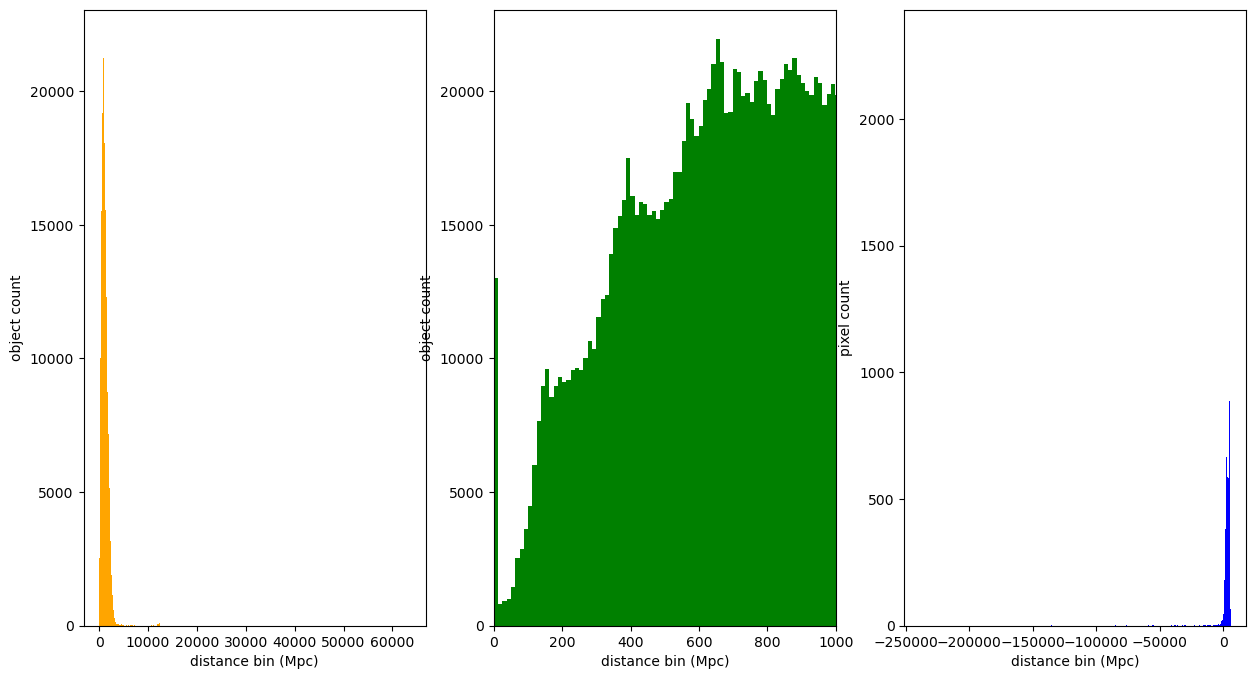

In [51]:
dist_max_99 = np.max(plt_skymap["DISTMU"])*u.Mpc
dist_min_99 = np.min(plt_skymap["DISTMU"])*u.Mpc
print(f"Our distance ranges from {dist_min_99} to {dist_max_99}")
print("Let's visualize the distance distribution of the LIGO event in the 99% credible region")

fig, ax = plt.subplots(ncols = 3, figsize = (15,8))


ax[0].hist(data_99["DIST_Z_MEAN"], bins = "auto", color = "orange")
ax[1].hist(data_99["DIST_Z_MEAN"], bins = "auto", color = "green")
ax[2].hist(plt_skymap["DISTMU"], bins = "auto", color = "blue")


for axis in ax:
    axis.set_xlabel("distance bin (Mpc)")

ax[0].set_ylabel("object count")
ax[1].set_ylabel("object count")
ax[2].set_ylabel("pixel count")

ax[1].set_xlim(0,1000)
    
plt.show()

In [52]:
len(skymap_99), len(data_99)

(17136, 2429015)

### To reduce our data even more, lets cut out the unreasonably far away objects

We simply take maximum and minimum distance we get from the LIGO skymap (i.e. DISTMU+-DISTERR) and check, whether every galaxy in that pixel falls inside this range.

*Note: We do this only for our own GW-follow ups*

In [53]:
if follow_up_others == False:
    z_selection_mask = data_99["DIST_Z_MEAN"] - data_99["DIST_Z_ERR"] - data_99["DIST_Z_COSMO_SIGMA"] <  data_99["DISTMU"] + data_99["DISTSIGMA"]
    z_selection_mask &= data_99["DIST_Z_MEAN"] + data_99["DIST_Z_ERR"] + data_99["DIST_Z_COSMO_SIGMA"] >  data_99["DISTMU"] - data_99["DISTSIGMA"]

    data_99_z = data_99[z_selection_mask]

    remaining_obj = np.size(np.where(z_selection_mask == True))
    deleted_obj = np.size(np.where(z_selection_mask == False))

    print(f"The z-range selection has deleted {deleted_obj} objects from originally {deleted_obj+remaining_obj} in the data set")
    print(f"Therefore, we have {remaining_obj} objects left in the search region")

    highest_prob_dens = np.max(data_99_z["PROBDENSITY"])
    print(f"Our highest remaing probability density is {highest_prob_dens} compared to the originally highest prob density of {max_probdens_in_ligo}")
    print(f"The difference in prob density is {max_probdens_in_ligo-highest_prob_dens}")

    
else:
    data_99_z = data_99
    remaining_obj = len(data_99_z)

The z-range selection has deleted 1455256 objects from originally 2429015 in the data set
Therefore, we have 973759 objects left in the search region
Our highest remaing probability density is 0.001325465889562678 compared to the originally highest prob density of 0.001325465889562678
The difference in prob density is 0.0


In [54]:
data_99_z[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
39628015885355689,150.007843278908,9.42653958951469,20220311,0.210020705255728,3.58092211507828e-05,0,25.8274745941162,86.3816070556641,172.61589050293,GALAXY,131074,0.0371329039335251,3.23985075950623,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1025.5853992246257,0.15229709232917973,100.89823062698069
39628015885357096,150.073471593864,9.46505478952279,20220113,0.357084851770514,5.48722042862276e-05,0,7.69501638412476,28.9897422790527,62.9424362182617,GALAXY,131074,0.0401519536972046,2.25408148765564,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1880.7799574486194,0.23337560722947587,198.68205517551868
39628015885357259,150.082156831908,9.53982511698847,20221124,0.367079965339814,6.31044842180793e-05,0,4.51560068130493,20.3098297119141,48.8351898193359,GALAXY,131074,0.03929078951478,1.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1942.4151035365376,0.26838979825408504,206.10468823452675
39628015889547872,150.157733647902,9.50824685205413,20220113,0.286336493872942,9.55255290452772e-05,0,4.72777128219604,18.5015392303467,42.0057830810547,GALAXY,131074,0.0417047068476677,4.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1456.8792294552545,0.4062898550141651,148.93152680603043
39628015885356767,150.059114207401,9.46358622978681,20220113,0.367720700809151,1.29024434107988e-05,0,7.07731580734253,16.1731739044189,27.0104961395264,GALAXY,131074,0.0393442809581757,1.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1946.3804761956428,0.05487330366223161,206.58378832806835


### get the apparent, absolute magnitudes and luminosities

in order to do this: flux > 0 selection  and gal ext correction

In [55]:
# get the apparent mags
orig_len = len(data_99_z)
data_99_z = data_99_z[data_99_z["FLUX_R"] > 0] # flux selection (only ones above 0)
print(f"had to cut out {len(data_99_z)-orig_len} objects due to bad fluxes")
data_99_z["MW_TRANSMISSION"] = gs.mw_transmission_from_data_table(data = data_99_z, band = "r")
#data_99_z["FLUX_R"] = data_99_z["FLUX_R"]/data_99_z["MW_TRANSMISSION"]

app_mag_r = gs.app_mag(data_99_z["FLUX_R"], mw_transmission = data_99_z["MW_TRANSMISSION"])
flux_selection_cut = len(data_99_z)

# get the absolute mags
abs_mag_r = gs.abs_mag(app_mag_r, data_99_z["Z"], 0,0,0)

# get the luminosities
lums_r = gs.lum(abs_mag_r, band = "r")

had to cut out 0 objects due to bad fluxes


In [56]:
data_f = hstack([data_99_z, Table({"APP_MAG_R": app_mag_r}), Table({"ABS_MAG_R": abs_mag_r}), Table({"LUM_R": lums_r})])

In [57]:
data_f[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA,MW_TRANSMISSION,APP_MAG_R,ABS_MAG_R,LUM_R
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc,,,,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628015885355689,150.007843278908,9.42653958951469,20220311,0.210020705255728,3.58092211507828e-05,0,25.8274745941162,86.3816070556641,172.61589050293,GALAXY,131074,0.0371329039335251,3.23985075950623,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1025.5853992246257,0.15229709232917973,100.89823062698069,0.9282811260782516,17.578145602383774,-22.566995251107254,5.736300091263263e+36
39628015885357096,150.073471593864,9.46505478952279,20220113,0.357084851770514,5.48722042862276e-05,0,7.69501638412476,28.9897422790527,62.9424362182617,GALAXY,131074,0.0401519536972046,2.25408148765564,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1880.7799574486194,0.23337560722947587,198.68205517551868,0.92268134388548,18.757018462599433,-22.705474307975038,6.516636339119759e+36
39628015885357259,150.082156831908,9.53982511698847,20221124,0.367079965339814,6.31044842180793e-05,0,4.51560068130493,20.3098297119141,48.8351898193359,GALAXY,131074,0.03929078951478,1.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1942.4151035365376,0.26838979825408504,206.10468823452675,0.9242751926181327,19.145237536837904,-22.38730133601279,4.861320977332693e+36
39628015889547872,150.157733647902,9.50824685205413,20220113,0.286336493872942,9.55255290452772e-05,0,4.72777128219604,18.5015392303467,42.0057830810547,GALAXY,131074,0.0417047068476677,4.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1456.8792294552545,0.4062898550141651,148.93152680603043,0.9198144399110084,19.241230905616508,-21.66647331479525,2.5027823787635974e+36
39628015885356767,150.059114207401,9.46358622978681,20220113,0.367720700809151,1.29024434107988e-05,0,7.07731580734253,16.1731739044189,27.0104961395264,GALAXY,131074,0.0393442809581757,1.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1946.3804761956428,0.05487330366223161,206.58378832806835,0.9241761101296421,19.39239870366409,-22.14457025181267,3.887423568908617e+36


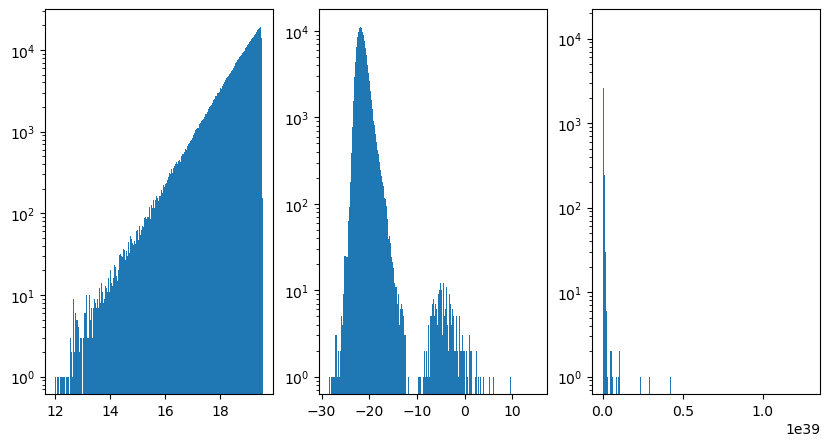

In [58]:
fig, ax = plt.subplots(ncols = 3, figsize=(10,5))

plot_names = ["APP_MAG_R", "ABS_MAG_R", "LUM_R"]
cnt = 0
for axis in ax:
    axis.hist(data_f[plot_names[cnt]], bins = "auto")
    axis.set_yscale("log")
    cnt += 1
plt.show()

In [59]:
# np.max(data_f["MW_TRANSMISSION"])

In [60]:
max_lum_r = np.max(data_f["LUM_R"])*u.W
prob_dens_max_lum = data_f[data_f["LUM_R"] == max_lum_r]["PROBDENSITY"]
print(f"The maximum luminosity in our cataloge in the r-band is {max_lum_r} with a prob density of {prob_dens_max_lum}")

The maximum luminosity in our cataloge in the r-band is 1.2922193013175082e+39 W with a prob density of     PROBDENSITY     
--------------------
8.42104428353149e-05


In [61]:
arg_errfc = abs(data_f["DIST_Z_MEAN"]-data_f["DISTMU"])/(data_f["DIST_Z_ERR"]**2+data_f["DISTSIGMA"]**2+data_f["DIST_Z_COSMO_SIGMA"].value**2)
P_gal_unnorm = data_f["LUM_R"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc))
#dist_mean*u.Mpc, dist_std*u.Mpc
arg_errfc_c = abs(data_f["DIST_Z_MEAN"].value-dist_mean)/(data_f["DIST_Z_ERR"].value**2+dist_std**2+data_f["DIST_Z_COSMO_SIGMA"].value**2)
P_gal_unnorm_const = data_f["LUM_R"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc_c))

# now lets quickly normalize

P_gal_sum = np.sum(P_gal_unnorm)
P_gal_const_sum = np.sum(P_gal_unnorm_const)

P_gal = 1/P_gal_sum * P_gal_unnorm
P_gal_const = 1/P_gal_const_sum * P_gal_unnorm_const

### Get the missed fraction of DESI due to mass/luminosity incompleteness

$$f_{missed} =  \frac{\int_{-\infty}^{\infty} dm 10^{-0.4m}\left(1-\frac{Hist\cdotw}{Schechter}\right)\cdot Schechter}{\int_{-\infty}^{\infty}dm 10^{-0.4m}\cdot Schechter}$$

In [62]:
# get the Schechter model, see 1/V estimator, bin size of half a mag
from astropy.modeling.models import Schechter1D

phi_star = 0.0017411666759990893
m_star = -21.938911723873762
alpha = -1.0776969153907823

schechter_model = Schechter1D(phi_star, m_star, alpha)

In [63]:
data_min_dist = np.min(data_f["DIST_Z_MEAN"])*u.Mpc
data_max_dist = np.max(data_f["DIST_Z_MEAN"])*u.Mpc

In [64]:
abs_mag_max = np.max(data_f["ABS_MAG_R"])
abs_mag_min = np.min(data_f["ABS_MAG_R"])

bins = np.arange(abs_mag_min, abs_mag_max, 0.5)

hist, bins = np.histogram(data_f["ABS_MAG_R"], bins =  bins)
hist = hist/(area_99.to_value(u.deg**2)*(data_max_dist-data_min_dist).value*10**0) # completely wrong normalization

In [65]:
abs_mag_min, abs_mag_max

(-28.448756152353454, 15.031811713262377)

In [66]:
data_min_dist, data_max_dist, (data_max_dist-data_min_dist).value*10**6

(<Quantity 6.28676311e-05 Mpc>, <Quantity 8327.41504574 Mpc>, 8327414982.87297)

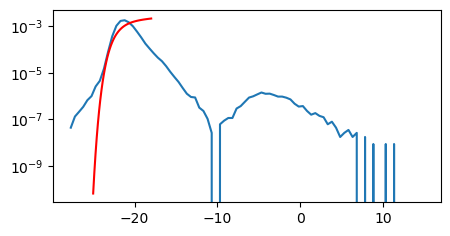

In [67]:
fig, ax = plt.subplots(figsize = (5,2.5))
bins_center = bins[1:]-(bins[1]-bins[2])/2
ax.plot(bins_center, hist, label = "wrongly normalized distribution")
ax.plot(np.linspace(-25,-18), schechter_model(np.linspace(-25,-18)),  label = "some schechter fit", color = "red")

ax.set_yscale("log")
plt.show()

In [68]:
hist

array([4.42257008e-08, 1.32677102e-07, 2.12283364e-07, 3.44960466e-07,
       6.63385512e-07, 9.90655699e-07, 2.57393579e-06, 4.45795064e-06,
       1.47448487e-05, 7.80848974e-05, 3.61270905e-04, 1.01103490e-03,
       1.63553718e-03, 1.74830387e-03, 1.42335111e-03, 9.61236762e-04,
       5.63417738e-04, 3.20149848e-04, 1.74364248e-04, 1.07778033e-04,
       6.76653223e-05, 4.39072758e-05, 3.09049197e-05, 1.90258965e-05,
       1.08706773e-05, 6.52771344e-06, 4.00684849e-06, 2.21128504e-06,
       1.25600990e-06, 9.11049437e-07, 8.66823736e-07, 3.18425046e-07,
       2.29973644e-07, 1.06141682e-07, 2.65354205e-08, 0.00000000e+00,
       6.19159812e-08, 8.84514017e-08, 1.14986822e-07, 1.14986822e-07,
       2.91889625e-07, 3.71495887e-07, 5.66088971e-07, 8.57978596e-07,
       9.72965418e-07, 1.17640364e-06, 1.41522243e-06, 1.24716476e-06,
       1.26485504e-06, 1.10564252e-06, 9.46429998e-07, 9.46429998e-07,
       8.49133456e-07, 7.16456353e-07, 4.68792429e-07, 3.53805607e-07,
      

In [69]:
from scipy.integrate import quad

def hist_func(M):
    # https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    # make sure array is a numpy array
    # array = np.array(array)
    idx = (np.abs(hist - M)).argmin()
    val = hist[idx]
    #print(f"val {val}")
    return val

def num_func(M):
    #print(f"M is {M}")
    schechter_val = schechter_model(M)
    #print(f"schechter Val: {schechter_val}")
    lum_factor = 10**(-0.4*M)
    #print(f"lum factor {lum_factor}")
    weighting_coverage = (1-hist_func(M)/(schechter_val))
    #print(f"weighting_coverage: {weighting_coverage}")
    final_val = lum_factor*weighting_coverage*schechter_val
    #print(f"final value: {final_val}")
    return final_val
def denom_func(M):
    lum_factor = 10**(-0.4*M)
    schechter_val = schechter_model(M)
    final_val = lum_factor*schechter_val

    return final_val

    
    

numerator = quad(num_func, -28, -18)
denominator = quad(denom_func, -28, -18)

print(numerator)
print(denominator)

f_missed = numerator[0]/denominator[0]

print(f_missed)

(1052592.2749107545, 0.0003165349709348675)
(1052592.2749107545, 0.0003165349709348675)
1.0


In [70]:
data_f = hstack([data_f, Table({"P_GAL": P_gal.value}), Table({"P_GAL_C": P_gal_const.value})])

In [71]:
data_f[:]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA,MW_TRANSMISSION,APP_MAG_R,ABS_MAG_R,LUM_R,P_GAL,P_GAL_C
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc,,,,W,,
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628015885355689,150.007843278908,9.42653958951469,20220311,0.210020705255728,3.58092211507828e-05,0,25.8274745941162,86.3816070556641,172.61589050293,GALAXY,131074,0.0371329039335251,3.23985075950623,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1025.5853992246257,0.15229709232917973,100.89823062698069,0.9282811260782516,17.578145602383774,-22.566995251107254,5.736300091263263e+36,3.851400666067741e-05,3.857557866750903e-05
39628015885357096,150.073471593864,9.46505478952279,20220113,0.357084851770514,5.48722042862276e-05,0,7.69501638412476,28.9897422790527,62.9424362182617,GALAXY,131074,0.0401519536972046,2.25408148765564,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1880.7799574486194,0.23337560722947587,198.68205517551868,0.92268134388548,18.757018462599433,-22.705474307975038,6.516636339119759e+36,4.375082283395577e-05,4.383373703425921e-05
39628015885357259,150.082156831908,9.53982511698847,20221124,0.367079965339814,6.31044842180793e-05,0,4.51560068130493,20.3098297119141,48.8351898193359,GALAXY,131074,0.03929078951478,1.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1942.4151035365376,0.26838979825408504,206.10468823452675,0.9242751926181327,19.145237536837904,-22.38730133601279,4.861320977332693e+36,3.26272556484694e-05,3.269993147240942e-05
39628015889547872,150.157733647902,9.50824685205413,20220113,0.286336493872942,9.55255290452772e-05,0,4.72777128219604,18.5015392303467,42.0057830810547,GALAXY,131074,0.0417047068476677,4.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1456.8792294552545,0.4062898550141651,148.93152680603043,0.9198144399110084,19.241230905616508,-21.66647331479525,2.5027823787635974e+36,1.6844363150197135e-05,1.6832796927178336e-05
39628015885356767,150.059114207401,9.46358622978681,20220113,0.367720700809151,1.29024434107988e-05,0,7.07731580734253,16.1731739044189,27.0104961395264,GALAXY,131074,0.0393442809581757,1.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1946.3804761956428,0.05487330366223161,206.58378832806835,0.9241761101296421,19.39239870366409,-22.14457025181267,3.887423568908617e+36,2.6090325805255807e-05,2.6148988463482382e-05
39628015885355510,149.999273619651,9.47155615272884,20220113,0.226518883531726,8.47781461792303e-06,0,8.31970977783203,17.1523151397705,30.0975227355957,GALAXY,131074,0.0359519720077515,0.67070198059082,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1116.414510118312,0.03605550593908233,110.77724109704671,0.9304807731154824,19.33596164044689,-20.993519931600837,1.346609690181684e+36,9.047172978234143e-06,9.055936826911118e-06
39628009921057991,150.115103485439,9.35172821843265,20220113,0.255901115526701,7.79196620292618e-05,0,4.72585391998291,17.6568298339844,36.421501159668,GALAXY,131074,0.0421106144785881,4.0,703076,0.001325465889562678,1413.6713646724643,391.4435717005969,4.6475050409402765e-07,1281.507847816482,0.3314040048532316,129.06366634566314,0.9190664678582765,19.291085473986108,-21.337995066764975,1.84940398626001e+36,1.2439491330217941e-05,1.2437800051885493e-05
39628015885356697,150.056728524058,9.49339213569857,20220113,0.306393595644253,1.39032414838295e-05,0,13.6409044265747,32.4617118835449,66.1757965087891,GALAXY,131074,0.0388548634946346,1.0,703076,0.001325465889562678,1413.6713646724643,391

## Analyse the data: How much luminosity do we cover? Which galaxies should we observe?

Lets look into what information we can retrieve from here. First we define, how many galaxies we could observe (N_galaxies).

We then calculate the luminosity (lum) from all the galaxies in this area, i.e. the total luminosity. From there do some comparison between the covered luminosity and total luminosity depending on the ranking by probability:
- simple "Maximum lum that could be covered" by looking at the brightest galaxies
- Calculate the probability this way (done above) (from https://arxiv.org/pdf/1710.05452.pdf w/o normalization), both using a static and variable distance and error: $$P_{gal} = k^{-1}\tilde{L_z}(1-f_{missed})\cdot P_{2D}\left(1-\text{erf}\left(\frac{|D_{Gal}-D_{LVC}|}{\sigma_{D,gal}^{2}+\sigma_{D,LVC}^{2}+\sigma_{D,cosmology}^{2}}\right)\right)$$
- others may follow...

Since we have the actual luminosity (here in r-band though), we don't need to again calculate the $$\tilde{L}_{gal}$$ values. In the mentioned paper, they only use a fixed distance and error for the LIGO data. I will try both, to get an idea what the differences are.

In [72]:
N_galaxies = 200 # how many galaxies we can cover

In [73]:
total_lum = np.sum(data_f["LUM_R"])

### Compare lum with luminosity ranking

https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10

In [74]:
data_sort_by_lums = data_f.group_by("LUM_R")
data_sort_by_lums = data_sort_by_lums[::-1]

In [75]:
lum_after_N_highest = np.sum(data_sort_by_lums["LUM_R"][:N_galaxies])

In [76]:
print(f"The theoretical maximum luminosity we could cover is {lum_after_N_highest}, i.e. {lum_after_N_highest*100/total_lum} % of the total luminosity")
print("The TARGETID values of these galaxies are: \n", data_sort_by_lums["TARGETID"][:N_galaxies])

The theoretical maximum luminosity we could cover is 5.137247857951115e+40, i.e. 1.6465299573612726 % of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID    
-----------------
39632966992791807
39633275865535641
39632956913881776
39633049826103549
39633260686347178
39633260636013725
39628341443038500
39633275894892167
39633001704851064
39633184295487333
              ...
39628199906249014
39632957039710190
39633011351748679
39632961968016791
39633343217664092
39628307855054494
39628482031915778
39633275831977089
39628428835553700
39633006578633191
39633279594269322
Length = 200 rows


### Compare lum with P_Gal ranking

In [77]:
data_sort_by_PGal = data_f.group_by("P_GAL")
data_sort_by_PGal = data_sort_by_PGal[::-1]

lum_after_N_PGal = np.sum(data_sort_by_PGal["LUM_R"][:N_galaxies])

In [78]:
print(f"The maximum luminosity we cover when ranked by P_gal is {lum_after_N_PGal}, i.e. {lum_after_N_PGal*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "TARGETID", "P_GAL"][:N_galaxies])

The maximum luminosity we cover when ranked by P_gal is 3.2032428895285863e+40, i.e. 1.0266655462516117% of the total luminosity
The TARGETID values of these galaxies are: 
    TARGET_RA        TARGET_DEC    ...      TARGETID             P_GAL         
---------------- ---------------- ... ----------------- ----------------------
271.476659719351 30.3559718805515 ... 39628487287378587  0.0014520737772738385
271.069028055204 35.8629430498743 ... 39632996898180271  0.0013263032640971266
265.857944641287 25.9960447673049 ... 39628396564579048  0.0009920246683903398
263.426014928104 22.8065935554236 ... 39628324925867780  0.0009361290204050026
 279.03546892617 35.2949649789273 ... 39632987154809486  0.0009283532238255114
271.440520469831 34.3112518948741 ... 39632967168951922  0.0008674861300933135
272.495468636351  37.558329811266 ... 39633030901402666  0.0008616499368930134
270.346868359302  33.400087370352 ... 39632952086234108  0.0008511917614739558
279.109218965033 36.7455711697037 ..

In [79]:
data_sort_by_PGal_C = data_f.group_by("P_GAL_C")
data_sort_by_PGal_C = data_sort_by_PGal_C[::-1]

lum_after_N_PGal_C = np.sum(data_sort_by_PGal_C["LUM_R"][:N_galaxies])

In [80]:
print(f"The maximum luminosity we cover when ranked by P_gal_C is {lum_after_N_PGal_C}, i.e. {lum_after_N_PGal_C*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal_C["TARGETID", "P_GAL"][:N_galaxies])

The maximum luminosity we cover when ranked by P_gal_C is 3.2032428895285863e+40, i.e. 1.0266655462516117% of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID             P_GAL         
----------------- ----------------------
39628487287378587  0.0014520737772738385
39632996898180271  0.0013263032640971266
39628396564579048  0.0009920246683903398
39628324925867780  0.0009361290204050026
39632987154809486  0.0009283532238255114
39632967168951922  0.0008674861300933135
39633030901402666  0.0008616499368930134
39632952086234108  0.0008511917614739558
39633016519133122  0.0007002727183661701
39628341443038500   0.000622048269043035
              ...                    ...
39628352784439032 0.00012187687307071311
39628094767628754  0.0001214044882485558
39632952073651474 0.00012141978425557805
39633045237536717 0.00012130657413632543
39627861312668402 0.00012101045570357621
39628257338853965 0.00012063868461679418
39628035586007679  0.0001198105598350156
3962

## Now lets do some final steps, including exporting the list

We want to cut out galaxies that are not observable by Wendelstein. For this we need the date (to calculate alt and az; we do this for three times to check observability) and Wendelstein location.

In [81]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from datetime import datetime
from suntimes import SunTimes

#date
day = datetime(2023,1,6)

def conv_to_deg(deg, arcmin, arcsec):
    return (deg+ arcmin/60+ arcsec/3600)*u.deg
Wendelstein_loc = EarthLocation(lat = conv_to_deg(47, 42, 13.1), lon = conv_to_deg(12, 0, 43.4), height = 1838*u.m)

In [82]:
sun = SunTimes(Wendelstein_loc.lat.to_value(), Wendelstein_loc.lon.to_value(), Wendelstein_loc.height.to_value())
sun.riseutc(day)

datetime.datetime(2023, 1, 6, 3, 6)

In [83]:
r = rq.get('https://api.sunrise-sunset.org/json', params={'lat': Wendelstein_loc.lat.to_value(), 'lng': Wendelstein_loc.lon.to_value()}).json()['results']

In [84]:
r["sunrise"]

'3:13:23 AM'

In [85]:
print(f"These are the stats for {superevent_name} follow up :")

These are the stats for S230606z follow up :


In [86]:
data_min_z = np.min(data_sort_by_PGal["Z"])
data_max_z = np.max(data_sort_by_PGal["Z"])
print(f"Localization area: {area_99.to_value(u.deg**2)*u.deg**2} \nRedshift range in data: {data_min_z} to {data_max_z} \ncorresponding lum distance range: {data_min_dist*u.Mpc} to {data_max_dist*u.Mpc} \nhighest prob location is at RA = {ra.deg*u.deg} and dec = {dec.deg*u.deg} \ntotal No. of objects in desi data is {len(data_sort_by_PGal)}")


Localization area: 13576.414004935838 deg2 
Redshift range in data: 1.47823074756008e-08 to 1.22053343447484 
corresponding lum distance range: 6.286763107143094e-05 Mpc2 to 8327.415045740601 Mpc2 
highest prob location is at RA = 150.1171875 deg and dec = 9.442777526802821 deg 
total No. of objects in desi data is 973759


In [87]:
data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "Z", "P_GAL"][:N_galaxies].write(f'PGAL/PGAL_{superevent_name}.ecsv', delimiter=',', format='ascii', overwrite = True)

In [88]:
# add timing data to table, 